<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from torchsummary import summary

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [2]:
def get_fmnist_data_loaders(path, subset_size, batch_size, valid_batch_size=0):
    # Data specific transforms
    data_mean = (0.2860,)
    data_std = (0.3530,)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training data loader
    train_dataset = FashionMNIST(root=path, train=True, download=True, transform=xforms)

    # Create a subset of the entire dataset (TODO: ensure all classes are present)
    indices = torch.randperm(len(train_dataset))[:subset_size]
    train_subset = Subset(train_dataset, indices)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_subset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = FashionMNIST(
        root=path, train=False, download=True, transform=xforms
    )

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [4]:
train_N = 8000
batch_size = 64

# Let's use some shared space for the data (so that we don't have copies
# sitting around everywhere)
data_path = "/raid/cs152/cache/pytorch/data"

# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

train_loader, valid_loader = get_fmnist_data_loaders(data_path, train_N, batch_size)

Using 'cuda' device.


In [5]:
hidden_layer_neurons = [13, 17]

# The input layer size depends on the dataset
n0 = train_loader.dataset.dataset.data.shape[1:].numel()

# The output layer size depends on the dataset
nL = len(train_loader.dataset.dataset.classes)

# Preprend the input and append the output layer sizes
layer_sizes = [n0] + hidden_layer_neurons + [nL]
model = NeuralNetwork(layer_sizes).to(device)

summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-1                  10,205
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-3                   --
|    |    └─Linear: 3-3                  238
|    |    └─ReLU: 3-4                    --
|    └─Linear: 2-4                       180
Total params: 10,623
Trainable params: 10,623
Non-trainable params: 0


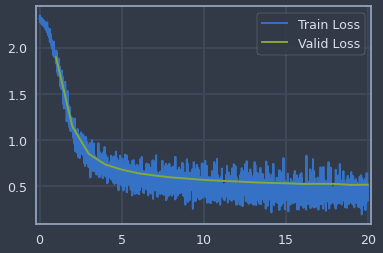

In [6]:
num_epochs = 20
learning_rate = 0.01
weight_decay = 0

model = NeuralNetwork(layer_sizes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Information for plots
train_losses = []
valid_losses = []

# A master bar for fancy output progress
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]

for epoch in mb:

    #
    # Training
    #
    model.train()

    train_N = len(train_loader.dataset)
    num_train_batches = len(train_loader)
    train_dataiterator = iter(train_loader)

    train_loss_mean = 0

    for batch in progress_bar(range(num_train_batches), parent=mb):

        # Grab the batch of data and send it to the correct device
        train_X, train_Y = next(train_dataiterator)
        train_X, train_Y = train_X.to(device), train_Y.to(device)

        # Compute the output
        train_output = model(train_X)

        # Compute loss
        train_loss = criterion(train_output, train_Y)

        num_in_batch = len(train_X)
        tloss = train_loss.item() * num_in_batch / train_N
        train_loss_mean += tloss
        train_losses.append(train_loss.item())

        # Update parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    #
    # Validation
    #
    model.eval()

    valid_N = len(valid_loader.dataset)
    num_valid_batches = len(valid_loader)

    valid_loss_mean = 0
    valid_correct = 0

    with torch.no_grad():

        # valid_loader is probably just one large batch, so not using progress bar
        for valid_X, valid_Y in valid_loader:

            valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

            valid_output = model(valid_X)

            valid_loss = criterion(valid_output, valid_Y)

            num_in_batch = len(valid_X)
            vloss = valid_loss.item() * num_in_batch / valid_N
            valid_loss_mean += vloss
            valid_losses.append(valid_loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = valid_output.argmax(1)

            # Sum up total number that were correct
            valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

    valid_accuracy = 100 * (valid_correct / valid_N)

    # Report information
    tloss = f"Train Loss = {train_loss_mean:.4f}"
    vloss = f"Valid Loss = {valid_loss_mean:.4f}"
    vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
    mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
    graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)